## get S2S climatology, from campaign p1 directory
-  use u850 and v850 as an example
- utilize climpred, dask
- write into (init, lead, member, lat, lon) -> output climatology in (week, month, member,lat lon)

In [2]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from climpred import HindcastEnsemble
import climpred
import pandas as pd

In [3]:
from climpred.preprocessing.shared import load_hindcast, set_integer_time_axis
#from climpred.preprocessing.mpi import get_path

In [4]:
import dask

In [5]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client


In [6]:
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='25GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project='P93300313', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(12)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status'})

# Setup your client
client = Client(cluster)


/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38570 instead
  expected, actual


In [7]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:45441,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## 1. define init_dates

In [8]:
date_rng = pd.date_range('20020101','20191231',freq='1D')
init_date = date_rng.where(date_rng.dayofweek==0).dropna()
init_date1 = pd.Series(init_date.format()).array

In [9]:
init_date

DatetimeIndex(['2002-01-07', '2002-01-14', '2002-01-21', '2002-01-28',
               '2002-02-04', '2002-02-11', '2002-02-18', '2002-02-25',
               '2002-03-04', '2002-03-11',
               ...
               '2019-10-28', '2019-11-04', '2019-11-11', '2019-11-18',
               '2019-11-25', '2019-12-02', '2019-12-09', '2019-12-16',
               '2019-12-23', '2019-12-30'],
              dtype='datetime64[ns]', length=939, freq=None)

In [10]:
months = [init_date.month_name().values[i][0:3].lower() for i in np.arange(0,init_date.size)]

In [11]:
days = [init_date[:].astype(str)[i].split("-")[2] for i in np.arange(0, init_date.size)]
#.split("-")[2]

In [12]:
date_string = [days[i]+months[i]+init_date.year[i].astype(str) for i in np.arange(0,init_date.size)]


In [13]:
date_string[52*14+10] = '28feb2016'

## 2. define functions `get_path_S2S` and `load_hindcast_S2S`to load S2S data 

In [14]:
import glob as _glob
import os as _os

def get_path_S2S(
    dir_base_experiment="/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS",
    subdir='p1/ua_850',
    init = '2002-01-07',
    init_str = date_string[0],
    member=1,
    model="cesm2cam6v2",
    output_stream="00z_d01_d46",
    ending="nc",
    ):  # “pragma: no cover”

    dir_outdata = f"{dir_base_experiment}/{subdir}"
    path = f"{dir_outdata}/*/*/ua_850_{model}_{init_str}_{output_stream}_m0{member}.{ending}"
    if _os.path.exists(_glob.glob(path)[0]):
        return path
    else:
        raise ValueError(f"Path not found or no access: {path}")


In [15]:
def load_hindcast_S2S(
    inits=['2002-01-07'],
    init_str = date_string[0],
    members=range(0,10),
    preprocess=None,
    lead_offset=1,
    parallel=True,
    engine=None,
    get_path=get_path_S2S,
    **get_path_kwargs,
):  # “pragma: no cover”
  
    init_list = []
    for init in init_str:
        print(f"Processing init {init} ...")
        member_list = []
        for member in members:
            # get path p
            p = get_path(member=member, init_str=init, **get_path_kwargs)
            # open all leads for specified member and init
            member_ds = xr.open_mfdataset(
                p,
                combine="nested",
                concat_dim="time",
                preprocess=preprocess,
                parallel=parallel,
                engine=engine,
                coords="minimal",  # expecting identical coords
                data_vars="minimal",  # expecting identical vars
                compat="override",  # speed up
                #chunks = {'time':365}
            ).squeeze()
            # set new integer time
            member_ds = set_integer_time_axis(member_ds)
            member_list.append(member_ds)
        member_ds = xr.concat(member_list, "member")
        init_list.append(member_ds)
    ds = xr.concat(init_list, "init").rename({"time": "lead"})
    ds["member"] = members
    # init must be datetime, datetimeindex, etc. if integer, the default will be years
    ds["init"] = pd.to_datetime(inits).array
    return ds


### define preprocess variable and time step

In [16]:
v = "ua_850"
def preprocess_1var(ds):
    """Only leave one variable `v` in dataset """
    return ds[v].to_dataset(name=v).squeeze()
#    return ds[0:7].to_dataset

## 3. Load data

In [17]:
ds = load_hindcast_S2S(inits=init_date, init_str=date_string, members=range(0, 10), preprocess=preprocess_1var, get_path=get_path_S2S)


Processing init 07jan2002 ...
Processing init 14jan2002 ...
Processing init 21jan2002 ...
Processing init 28jan2002 ...
Processing init 04feb2002 ...
Processing init 11feb2002 ...
Processing init 18feb2002 ...
Processing init 25feb2002 ...
Processing init 04mar2002 ...
Processing init 11mar2002 ...
Processing init 18mar2002 ...
Processing init 25mar2002 ...
Processing init 01apr2002 ...
Processing init 08apr2002 ...
Processing init 15apr2002 ...
Processing init 22apr2002 ...
Processing init 29apr2002 ...
Processing init 06may2002 ...
Processing init 13may2002 ...
Processing init 20may2002 ...
Processing init 27may2002 ...
Processing init 03jun2002 ...
Processing init 10jun2002 ...
Processing init 17jun2002 ...
Processing init 24jun2002 ...
Processing init 01jul2002 ...
Processing init 08jul2002 ...
Processing init 15jul2002 ...
Processing init 22jul2002 ...
Processing init 29jul2002 ...
Processing init 05aug2002 ...
Processing init 12aug2002 ...
Processing init 19aug2002 ...
Processing

In [18]:
ds

,Array,Chunk
Bytes,104.85 GiB,11.43 MiB
Shape,"(939, 10, 46, 181, 360)","(1, 1, 46, 181, 360)"
Count,56340 Tasks,9390 Chunks
Type,float32,numpy.ndarray


## 4. Get monthly climatology for each lead

### - week1

In [21]:
week1 = ds.isel(lead=slice(0,7))

In [22]:
# drop the last few days of the month to avoid counting in the next month
week1_sub = week1.where(week1.init.dt.day<27, drop=True)

In [24]:
week1_sub

,Array,Chunk
Bytes,13.64 GiB,1.74 MiB
Shape,"(803, 10, 7, 181, 360)","(1, 1, 7, 181, 360)"
Count,83397 Tasks,8030 Chunks
Type,float32,numpy.ndarray


In [25]:
week1_mon = week1_sub.groupby(week1_sub.init.dt.month).mean('init')

In [26]:
week1_mon

<xarray.Dataset>
Dimensions:  (lat: 181, lead: 7, lon: 360, member: 10, month: 12)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ua_850   (month, member, lead, lat, lon) float32 dask.array<chunksize=(1, 1, 7, 181, 360), meta=np.ndarray>

In [27]:
week1_mon_mean = week1_mon.mean('lead')
week1_mon_mean

,Array,Chunk
Bytes,29.83 MiB,254.53 kiB
Shape,"(12, 10, 181, 360)","(1, 1, 181, 360)"
Count,102937 Tasks,120 Chunks
Type,float32,numpy.ndarray


In [28]:
delayed_obj = week1_mon_mean.to_netcdf("/glade/scratch/huili7/S2S_data/S2S_ua850_week1_monclim.nc", compute=False)
results = delayed_obj.compute()

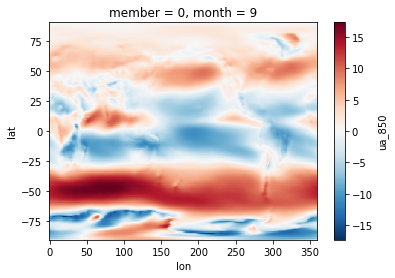

In [103]:
week1_mon_mean.ua_850.isel(member=0,month=8).plot()

### - week2

In [ ]:
week2 = ds.isel(lead=slice(7,14), init=slice(0,ds.init.size-1))

# get week2 start date, which is one week after the initiation date
week2['init'] = ds.init[1:ds.init.size].data

week2_sub =week2.where(week2.init.dt.day<27, drop=True)

week2_mon=week2_sub.groupby(week2_sub.init.dt.month).mean('init')

week2_mon_mean = week2_mon.mean('lead')

delayed_obj = week2_mon_mean.to_netcdf("/glade/scratch/huili7/S2S_data/S2S_ua850_week2_monclim.nc", compute=False)
results = delayed_obj.compute()

### -week3

In [23]:
week3 = ds.isel(lead=slice(14,21), init=slice(0,ds.init.size-2))
week3

week3['init'] = ds.init[2:ds.init.size].data
week3

week3_sub =week3.where(week3.init.dt.day<27, drop=True)
week3_mon = week3_sub.groupby(week3_sub.init.dt.month).mean('init')

week3_mon_mean = week3_mon.mean('lead')
week3_mon_mean

delayed_obj = week3_mon_mean.to_netcdf("/glade/scratch/huili7/S2S_data/S2S_ua850_week3_monclim.nc", compute=False)
results = delayed_obj.compute()

### -week4

In [27]:
week4 = ds.isel(lead=slice(21,28), init=slice(0,ds.init.size-3))
week4['init'] =ds.init[3:ds.init.size].data
week4

week4_sub = week4.where(week4.init.dt.day<27,drop=True)
week4_mon = week4_sub.groupby(week4_sub.init.dt.month).mean('init')

week4_mon_mean = week4_mon.mean('lead')
week4_mon_mean

delayed_obj = week4_mon_mean.to_netcdf("/glade/scratch/huili7/S2S_data/S2S_ua850_week4_monclim.nc", compute=False)
results = delayed_obj.compute()

### -week5 and week6

In [33]:
week5 = ds.isel(lead=slice(28,35), init=slice(0,ds.init.size-4))
week5['init'] =ds.init[4:ds.init.size].data
week5

week5_sub = week5.where(week5.init.dt.day<27,drop=True)
week5_mon = week5_sub.groupby(week5_sub.init.dt.month).mean('init')
week5_mon_mean = week5_mon.mean('lead')
week5_mon_mean

delayed_obj = week5_mon_mean.to_netcdf("/glade/scratch/huili7/S2S_data/S2S_ua850_week5_monclim.nc", compute=False)
results = delayed_obj.compute()

week6 = ds.isel(lead=slice(35,42), init=slice(0,ds.init.size-5))
week6['init'] =ds.init[5:ds.init.size].data
week6

week6_sub = week6.where(week6.init.dt.day<27,drop=True)
week6_mon = week6_sub.groupby(week6_sub.init.dt.month).mean('init')
week6_mon_mean = week6_mon.mean('lead')
week6_mon_mean

delayed_obj = week6_mon_mean.to_netcdf("/glade/scratch/huili7/S2S_data/S2S_ua850_week6_monclim.nc", compute=False)
results = delayed_obj.compute()